In [3]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [12]:
import dill
dill.dump_session('./data_bruckner/data/notebookData/2_width_vs_CorrLengthEXT.db')

In [4]:
import dill
dill.load_session('./data_bruckner/data/notebookData/2_width_vs_CorrLengthEXT.db')

In [5]:
def beta_from_corrLength(corrLen):
    beta = np.tan((np.exp(-1./corrLen)))
    return beta

In [6]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
corrLengths = np.linspace(2.5,10,20)
#corrLengths = np.array([1,1.5,2,2.5,3])
beta = beta_from_corrLength(corrLengths)
print beta
print corrLengths

[ 0.79277524  0.8558812   0.90917458  0.95481915  0.99437613  1.02900294
  1.05957744  1.08677851  1.11113994  1.13308762  1.15296567  1.17105535
  1.18758886  1.20275966  1.21673027  1.22963822  1.24160075  1.25271839
  1.26307784  1.27275433]
[  2.5          2.89473684   3.28947368   3.68421053   4.07894737
   4.47368421   4.86842105   5.26315789   5.65789474   6.05263158
   6.44736842   6.84210526   7.23684211   7.63157895   8.02631579
   8.42105263   8.81578947   9.21052632   9.60526316  10.        ]


In [7]:
#Defining Parameters
Num_configs = 10000
Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
N           = corrLengths*30 #The 30 factor was obtained by previous simulations where the system performed well with this sytems size
N           = N*0 + 30*10

print N

for i in np.arange(len(N)):
    N[i] = np.int(max(30,np.int(N[i]))) # We fix the minimum number of spins to 30

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

[ 300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.  300.
  300.  300.  300.  300.  300.  300.  300.  300.]


In [8]:
BM      = []
data    = []
results = []
RBM     = []

for i in np.arange(len(beta)):
    #Generate spins using Gibbs Sampling MCMC
    BM.append(bm.BM(N=N[i],nature='Spin'))

    #Define Couplings
    BM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
    BM[i].layer.couplings[0,-1] += beta[i]
    BM[i].layer.couplings[-1,0] += beta[i]
    
    #Generating the ising model data
    data.append(BM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

    #Train the model
    RBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
    results.append(RBM[i].fit(data[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))

KeyboardInterrupt: 

In [ ]:
# Fitting the Peak and calculating the width

from scipy.interpolate import UnivariateSpline
import pylab as pl

#Roll the array to put the peak in the centre
weightsAligned = []
spline = []
roots  = []
FWHM   = []

for i in np.arange(len(beta)):
#for i in np.arange(5):
    roll_val = -(np.argmax(abs(np.array(results[i]['W'])[-1,0,:])) - int(len(np.array(results[i]['W'])[-1,0,:])/2))
    weightsAligned.append(np.roll(np.array(results[i]['W'])[-1,0,:],roll_val))
    spline.append(UnivariateSpline(np.arange(len(np.array(results[i]['W'])[-1,0,:])),abs(weightsAligned[i])-np.max(abs(weightsAligned[i]))/2,s=0))
    roots.append(spline[i].roots())
    
    #Show the roots for visual verification
    pl.plot(np.arange(len(np.array(results[i]['W'])[-1,0,:])),weightsAligned[i])
    pl.axvspan(roots[i][0], roots[i][1], facecolor='g', alpha=0.5)
    pl.show()
    #I = input("Press Enter to continue...")
    
    FWHM.append(abs(roots[i][0]-roots[i][1]))
    
print FWHM
#plt.plot(np.array(results[1]['W'])[-1,0,:])

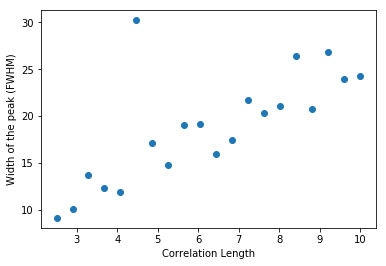

In [12]:
#Plot FWHM as a function of the correlation length

plt.scatter(corrLengths,FWHM)
plt.xlabel('Correlation Length')
plt.ylabel('Width of the peak (FWHM)')
plt.show()

## Estimate Width using the squares method

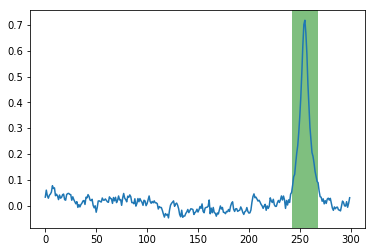

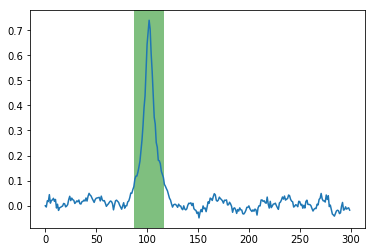

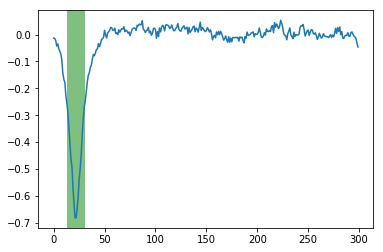

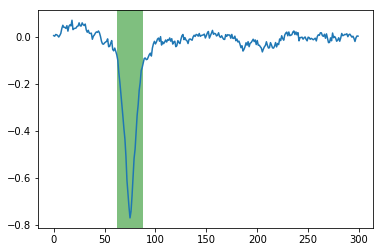

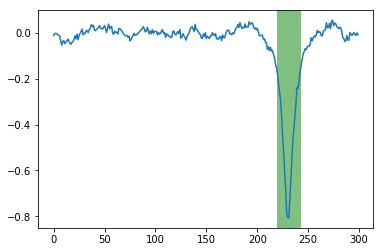

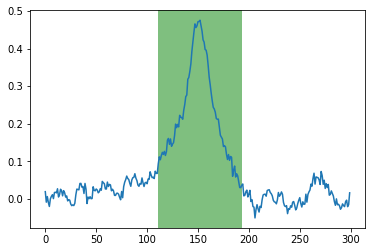

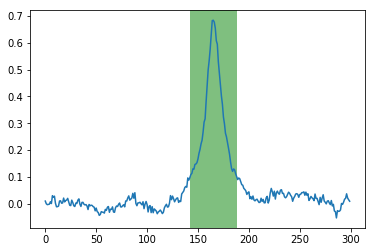

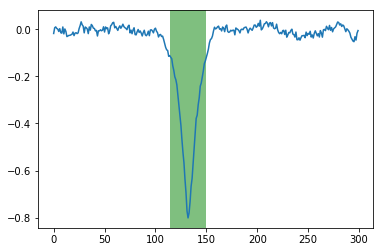

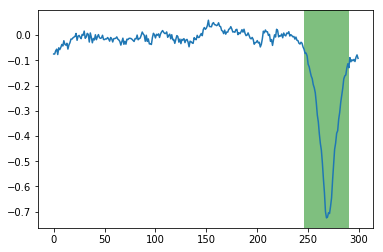

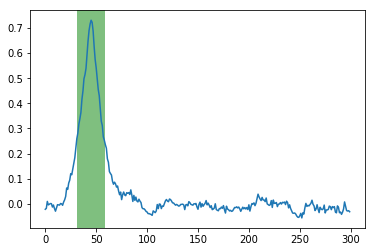

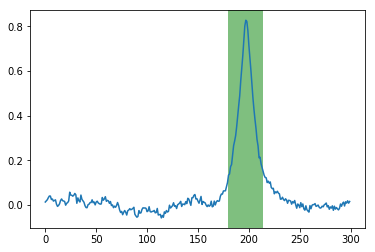

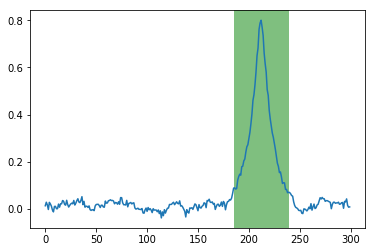

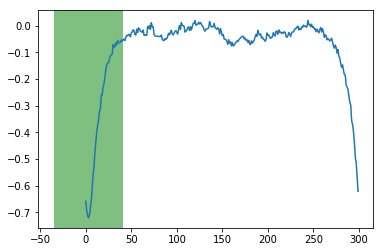

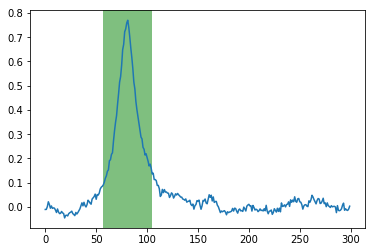

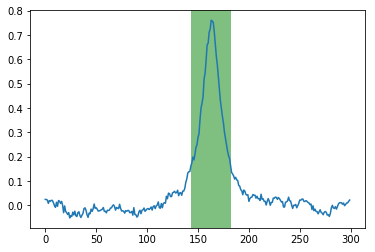

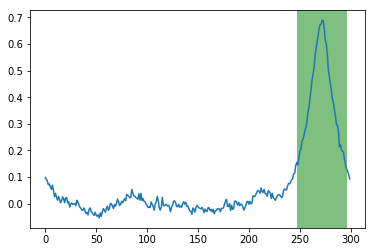

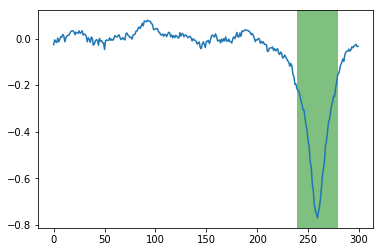

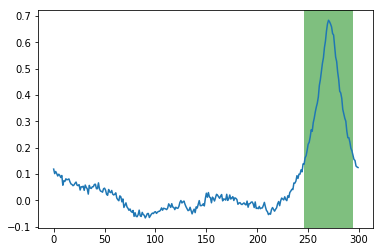

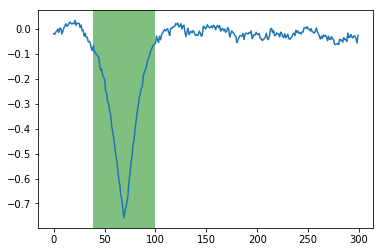

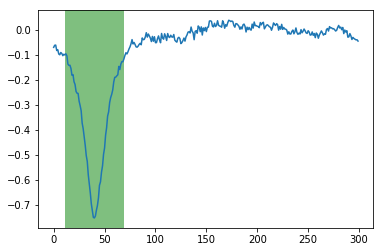

In [37]:
import peakWidth
width = []
avg_width = []
for i in np.arange(len(beta)):
    
    width.append(peakWidth.peakWidth(np.array(results[i]['W'])[:,0,:],plot=True,method='Squared')) 
    avg_width.append(np.sum(width[i][-100:-1])/100)

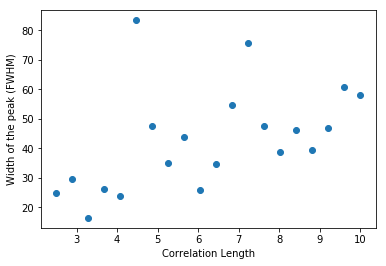

In [38]:
plt.scatter(corrLengths,avg_width)
plt.xlabel('Correlation Length')
plt.ylabel('Width of the peak (FWHM)')
plt.show()

## Data Collapse?

In [49]:
y = (np.array(FWHM)/corrLengths)
x = np.exp(-corrLengths/N)
print x

[ 0.99170129  0.99039728  0.98909498  0.9877944   0.98649552  0.98519836
  0.9839029   0.98260914  0.98131708  0.98002672  0.97873806  0.9774511
  0.97616582  0.97488224  0.97360034  0.97232013  0.9710416   0.96976476
  0.96848959  0.9672161 ]


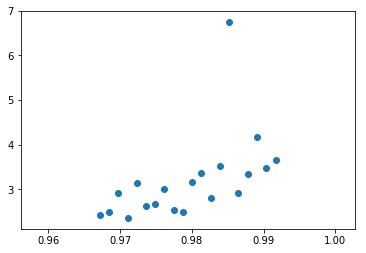

In [48]:
plt.scatter(x,y)

## Width and Correlation Length relation with Error bars from time variation

In [55]:
FWHM_avg = []
FWHM_error = [] 

for i in np.arange(len(beta)):
    FWHM_avg.append(np.mean(peakWidth.peakWidth(weight=np.array(results[i]['W'])[-500:-1,0,:])))
    FWHM_error.append(np.std(peakWidth.peakWidth(weight=np.array(results[i]['W'])[-500:-1,0,:])))

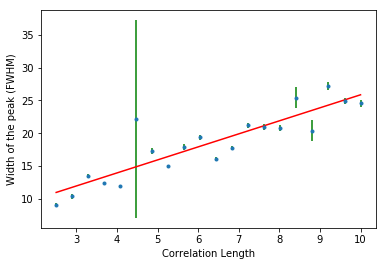

In [65]:
#Plot FWHM as a function of the correlation length

fit = np.polyfit(corrLengths,FWHM_avg, deg=1)
plt.plot(corrLengths, fit[0] * corrLengths + fit[1], color='red')
plt.errorbar(corrLengths,FWHM_avg,yerr=FWHM_error,xlolims=0,fmt='.',ecolor='g')
plt.xlabel('Correlation Length')
plt.ylabel('Width of the peak (FWHM)')
plt.show()

## True Error bars with multiple runs of the data generation and fitting

In [ ]:
%%capture captX

Xdata_big    = []
Xresults_big = []

XBM      = []
Xdata    = []
Xresults = []
XRBM     = []

Num_reps = 25

for j in range(Num_reps):
    
    Xdata_big.append(Xdata)
    Xresults_big.append(Xresults)
    
    XBM      = []
    Xdata    = []
    Xresults = []
    XRBM     = []
    
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        XBM.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        XBM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        XBM[i].layer.couplings[0,-1] += beta[i]
        XBM[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data
        Xdata.append(XBM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
        Xresults.append(XRBM[i].fit(Xdata[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))

In [ ]:
del Xdata_big[0]
del Xresults_big[0]

In [ ]:
import peakWidth
XFWHM_avg = []
XFWHM_error = []

for i in np.arange(len(beta)):
    
    t1 = np.zeros(Num_reps)
    
    for j in range(Num_reps-1):
        t1[j] = peakWidth.peakWidth(weight=np.array(Xresults_big[j][i]['W'])[-1,0,:])
        
    XFWHM_avg.append(np.mean(t1))
    XFWHM_error.append(np.std(t1))

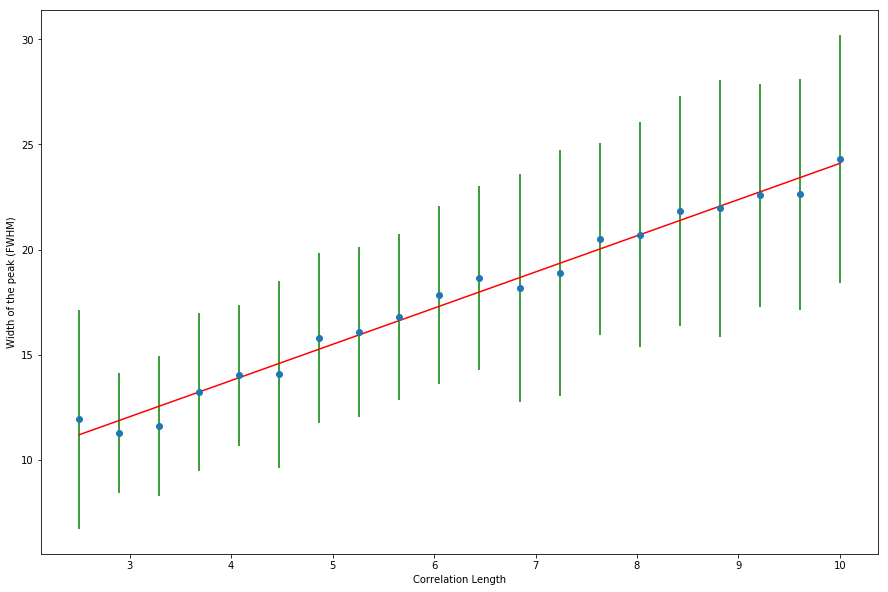

In [31]:
#Plot FWHM as a function of the correlation length
import numpy as np

plt.figure(figsize=(15,10))
Xfit = np.polyfit(corrLengths,XFWHM_avg, deg=1)
plt.plot(corrLengths, Xfit[0] * corrLengths + Xfit[1], color='red')
plt.errorbar(corrLengths,XFWHM_avg,yerr=XFWHM_error,xlolims=0,fmt='o',ecolor='g')
plt.xlabel('Correlation Length')
plt.ylabel('Width of the peak (FWHM)')
plt.show()

In [3]:
#Plot FWHM as a function of the correlation length
import numpy as np

plt.figure(figsize=(15,10))
Xfit = np.polyfit(corrLengths,XFWHM_avg, deg=1)
plt.plot(corrLengths, Xfit[0] * corrLengths + Xfit[1], color='red')
plt.errorbar(corrLengths,XFWHM_avg,yerr=XFWHM_error,xlolims=0,fmt='o',ecolor='g')
plt.xlabel('Correlation Length of the ising model (in number of visible units)',fontsize=20)
plt.ylabel('Width of the peak (in number of visible units)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

NameError: name 'corrLengths' is not defined